# Cisco - Ariel University API Security Detection Challenge 2023

## Student ID: 207276775
GitHub project: https://github.com/RazElbaz/API_security_challenge

The site that helped me find algorithms:
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 4 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,XSS,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,NaN,200 OK,text/html; charset=utf-8,22,NaN,200,text/html; charset=utf-8,"""Windows""",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,NaN,200 OK,application/json,41,NaN,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,Log Forging,401 UNAUTHORIZED,application/json,41,NaN,401,"{""error"": ""Not a number failed to parse""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,NaN,200 OK,application/json,871,NaN,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,XSS,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,200 OK,text/html; charset=utf-8,22,NaN,200,text/html; charset=utf-8,"""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,NaN,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,401 UNAUTHORIZED,application/json,41,NaN,401,"{""error"": ""Not a number failed to parse""}",NaN,NaN,NaN,NaN,NaN,Log Forging,Malware
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,200 OK,application/json,871,NaN,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182762,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,"en-US,en;q=0.5",none,same-origin,max-age=0,?1,document,['ttauth=vDA_pRaPgv5BX9UlIvE2-G5JEBJe4PvEXroOv...,"Sun, 18 Dec 2022 01:37:37 GMT",GET,http://127.0.0.1:5000/categories/check/name/Pr...,,200 OK,application/json,101,NaN,200,"{""category_id"": ""7"", ""category_name"": ""Produce...","""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
182763,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,?1,de-CH,none,same-origin,no-cache,?1,document,['cid=YQAQXREK77h1CZXs6lAoKHvBgZfKuaV4aEMuONaI...,"Sun, 18 Dec 2022 01:20:52 GMT",GET,http://127.0.0.1:5000/login/user?username=Sowi...,,401 UNAUTHORIZED,application/json,26,NaN,401,"{""error"": ""Access denied""}","""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
182764,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['ck=Y0mqGJ92oxXkiQMuhlP3oypr6p0wBFCvveiuxxe-R...,"Sun, 18 Dec 2022 01:22:10 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fp%3E...,,302 FOUND,text/html; c

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,None,None,None,None,None,XSS,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,200 OK,text/html; charset=utf-8,22,None,200,text/html; charset=utf-8,"""Windows""",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,None,None,None,None,None,None,None,None,None,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,None,200,"{""message"": ""Welcome to the Book Store!""}",None,None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,401 UNAUTHORIZED,application/json,41,None,401,"{""error"": ""Not a number failed to parse""}",None,None,None,None,None,Log Forging,Malware
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,200 OK,application/json,871,None,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,None,None,None,Benign,Benign


In [4]:
# #Median of two seperate columns
# df['request.headers.Accept-Encoding',
#                 'request.headers.Connection',
#                 'request.headers.Host',
#                 'request.headers.Accept',
#                 'request.method',
#                 'request.headers.Accept-Language',
#                 'request.headers.Sec-Fetch-Site',
#                 'request.headers.Sec-Fetch-Mode',
#                 'request.headers.Sec-Fetch-Dest',
#                 'request.headers.Sec-Fetch-User',
#                 'response.status',
#                'request.headers.User-Agent',
#                     'request.headers.Set-Cookie',
#                     'request.headers.Date',
#                     'request.url',
#                     'response.headers.Content-Type',
#                     'response.body',
#                     'response.headers.Location',
#                     'request.headers.Content-Length',
#                     'request.headers.Cookie',
#                     'response.headers.Set-Cookie',
#                     'request.headers.Sec-Ch-Ua-Mobile','request.body',
#                     'response.headers.Content-Length',
#                     'request.headers.Date'
  
#   "request.headers.Host",                         
# "request.headers.User-Agent",                 
# "request.headers.Accept-Encoding",             
# "request.headers.Accept",                     
# "request.headers.Connection",                    
# "request.headers.Sec-Ch-Ua-Mobile",            
# "request.headers.Accept-Language",                
# "request.headers.Sec-Fetch-Site",                 
# "request.headers.Sec-Fetch-Mode",
# "request.headers.Cache-Control",               
# "request.headers.Sec-Fetch-User",              
# "request.headers.Sec-Fetch-Dest",                 
# "request.headers.Set-Cookie",                  
# "request.method",                                
# "request.url",                                 
# "response.status",                              
# "response.headers.Content-Type",                
# "response.headers.Location",                  
# "response.status_code",                           
# "response.body",                             
# request.headers.Sec-Ch-Ua-Platform",         
# request.headers.Content-Length",            
# request.headers.Cookie",                     
# response.headers.Set-Cookie",              
# request.headers.Upgrade-Insecure-Requests",    
# attack_type                                 
# label                                      

  
  
  
#   ].median()

In [5]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date',
                    'request.headers.Cache-Control',
                    'request.headers.Upgrade-Insecure-Requests',
                    'request.headers.Sec-Ch-Ua-Platform']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
        
#     def a(row):  
#         return int(df['request.headers.Sec-Ch-Ua-Mobile'][1][1])
    def cat(row):  
        if row['request.headers.Sec-Ch-Ua-Mobile'] == '?0':
            return 0
        if row['request.headers.Sec-Ch-Ua-Mobile'] == '?1':
            return 1
        return 0

    df['request.headers.Sec-Ch-Ua-Mobile'] = df.apply(lambda row: cat(row), axis=1)

#     for column in df.columns[['request.headers.Sec-Ch-Ua-Mobile'].tolist():
#         df[column].fillna(int(df['request.headers.Sec-Ch-Ua-Mobile'][i][1]))
#         df['request.headers.Sec-Ch-Ua-Mobile'] = df.apply(lambda row: int(df['request.headers.Sec-Ch-Ua-Mobile'][i][1]), axis=1)
                             
#     for i in df['request.headers.Sec-Ch-Ua-Mobile'].length()
#         df['request.headers.Sec-Ch-Ua-Mobile']=int(df['request.headers.Sec-Ch-Ua-Mobile'][i][1])

    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Location,response.status_code,response.body,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,0,0.000000,1,0,0,0,2,1,1,0,1,-0.359211,0,0.577350,2,-1.0,0.0,302,-1.000000,-1.0,-1.0,-1.0,XSS,Malware
1,0,0.500000,1,0,0,0,3,1,2,0,1,-0.861640,0,1.000000,0,-1.0,-1.0,200,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
2,0,0.577350,0,0,0,0,0,0,0,1,0,-1.000000,0,0.707107,0,-1.0,-1.0,200,0.000000,-1.0,-1.0,-1.0,Benign,Benign
3,0,-0.816497,1,0,0,0,1,1,2,0,1,-0.426401,0,0.000000,4,-1.0,-1.0,401,0.408248,-1.0,-1.0,-1.0,Log Forging,Malware
4,0,0.632456,631,0,0,1,2,1,2,0,1,-0.880451,1,0.377964,0,-1.0,-1.0,200,-0.255551,-1.0,-1.0,-1.0,Benign,Benign


In [6]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182767 entries, 0 to 182766
Data columns (total 24 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   request.headers.Host              182767 non-null  int32  
 1   request.headers.User-Agent        182767 non-null  float64
 2   request.headers.Accept-Encoding   182767 non-null  int32  
 3   request.headers.Accept            182767 non-null  int32  
 4   request.headers.Connection        182767 non-null  int32  
 5   request.headers.Sec-Ch-Ua-Mobile  182767 non-null  int64  
 6   request.headers.Accept-Language   182767 non-null  int32  
 7   request.headers.Sec-Fetch-Site    182767 non-null  int32  
 8   request.headers.Sec-Fetch-Mode    182767 non-null  int32  
 9   request.headers.Sec-Fetch-User    182767 non-null  int32  
 10  request.headers.Sec-Fetch-Dest    182767 non-null  int32  
 11  request.headers.Set-Cookie        182767 non-null  f

In [7]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.headers.Location', 'response.status_code', 'response.body', 'request.headers.Content-Length', 'request.headers.Cookie', 'response.headers.Set-Cookie']


request.headers.Host                  int32
request.headers.User-Agent          float64
request.headers.Accept-Encoding       int32
request.headers.Accept                int32
request.headers.Connection            int32
request.headers.Sec-Ch-Ua-Mobile      int64
request.headers.Accept-Language       int32
request.headers.Sec-Fetch-Site        int32
request.headers.Sec-Fetch-Mode        int32
request.headers.Sec-Fetch-User        int32
request.headers.Sec-Fetch-Dest        int32
request.headers.Set-Cookie          float64
request.method                        int32
request.url                         float64
response.status                       int32
response.headers.Content-Type       float64
response.headers.Location           float64
response.status_code                  int64
response.body                       float64
request.headers.Content-Length      float64
request.headers.Cookie              float64
response.headers.Set-Cookie         float64
attack_type                     

## Train test split

In [8]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(150508, 22) (150508,)
(32259, 22) (32259,)


Counter({'Malware': 39336, 'Benign': 143431})

## Model choosing and fitting

## Result printout

In [9]:
def ResultPrintout(model):
    # We print our results
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(model_report)

In [10]:
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Location,response.status_code,response.body,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,0,0.000000,1,0,0,0,2,1,1,0,1,-0.359211,0,0.577350,2,-1.0,0.0,302,-1.000000,-1.0,-1.0,-1.0,XSS,Malware
1,0,0.500000,1,0,0,0,3,1,2,0,1,-0.861640,0,1.000000,0,-1.0,-1.0,200,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
2,0,0.577350,0,0,0,0,0,0,0,1,0,-1.000000,0,0.707107,0,-1.0,-1.0,200,0.000000,-1.0,-1.0,-1.0,Benign,Benign
3,0,-0.816497,1,0,0,0,1,1,2,0,1,-0.426401,0,0.000000,4,-1.0,-1.0,401,0.408248,-1.0,-1.0,-1.0,Log Forging,Malware
4,0,0.632456,631,0,0,1,2,1,2,0,1,-0.880451,1,0.377964,0,-1.0,-1.0,200,-0.255551,-1.0,-1.0,-1.0,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182762,0,-0.408248,631,0,0,1,3,1,1,0,1,0.584472,0,0.000000,0,-1.0,-1.0,200,0.408248,-1.0,-1.0,-1.0,Benign,Benign
182763,0,-0.755929,1,0,0,1,2,1,1,0,1,-0.484182,0,0.774597,4,-1.0,-1.0,401,-0.577350,-1.0,-1.0,-1.0,Benign,Benign
182764,0,-0.755929,1,0,0,1,4,1,2,0,1,-0.577350,0,0.480384,2,-1.0,0.0,302,-1.000000,-1.0,-1.0,-1.0,XSS,Malware
182765,0,0.774597,1,0,0,1,4,1,1,0,1,-0.798621,0,0.000000,5,-1.0,-1.0,404,0.408248,-1.0,-1.0,-1.0,Benign,Benign


### Model 1- RandomForestClassifier()

[('Benign', 118115), ('Malware', 32393)]
              precision    recall  f1-score   support

      Benign    0.96654   0.96753   0.96703     25316
     Malware    0.88116   0.87786   0.87951      6943

    accuracy                        0.94823     32259
   macro avg    0.92385   0.92270   0.92327     32259
weighted avg    0.94816   0.94823   0.94820     32259



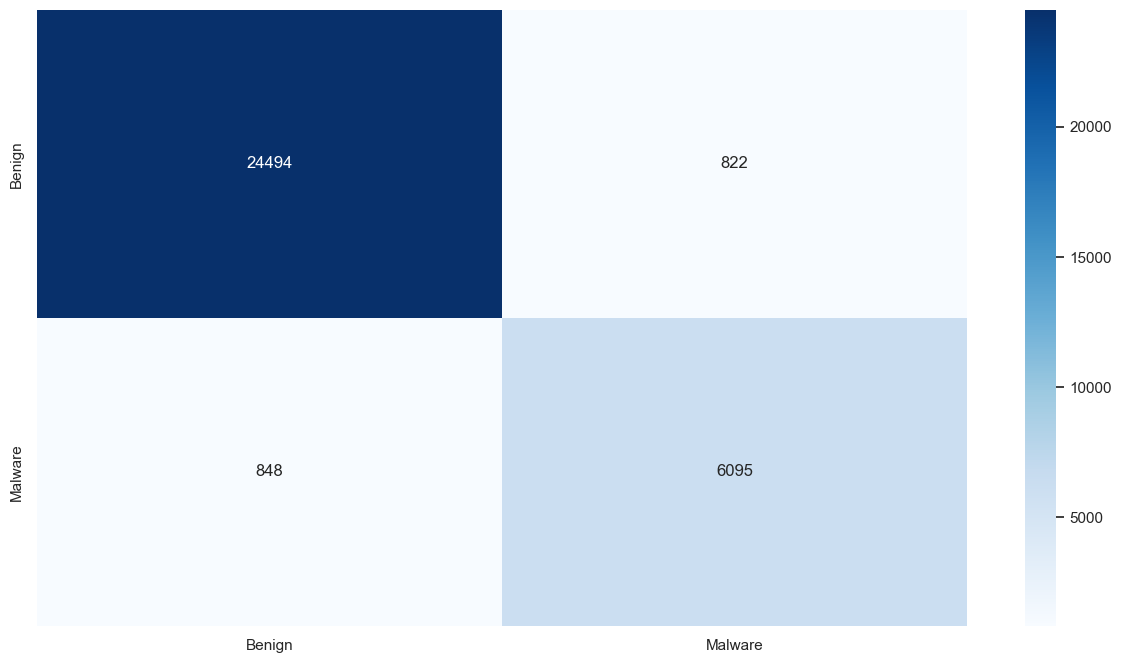

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier()

parameters = {"n_estimators": [100,200,300,400]}

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
clf = GridSearchCV(clf, parameters)
# Train Model
clf.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
clf = clf.best_estimator_
ResultPrintout(clf)

### Model 2- DecisionTreeClassifier()

[('Benign', 118115), ('Malware', 32393)]
              precision    recall  f1-score   support

      Benign    0.96098   0.92815   0.94428     25316
     Malware    0.76703   0.86260   0.81201      6943

    accuracy                        0.91404     32259
   macro avg    0.86401   0.89537   0.87815     32259
weighted avg    0.91924   0.91404   0.91581     32259



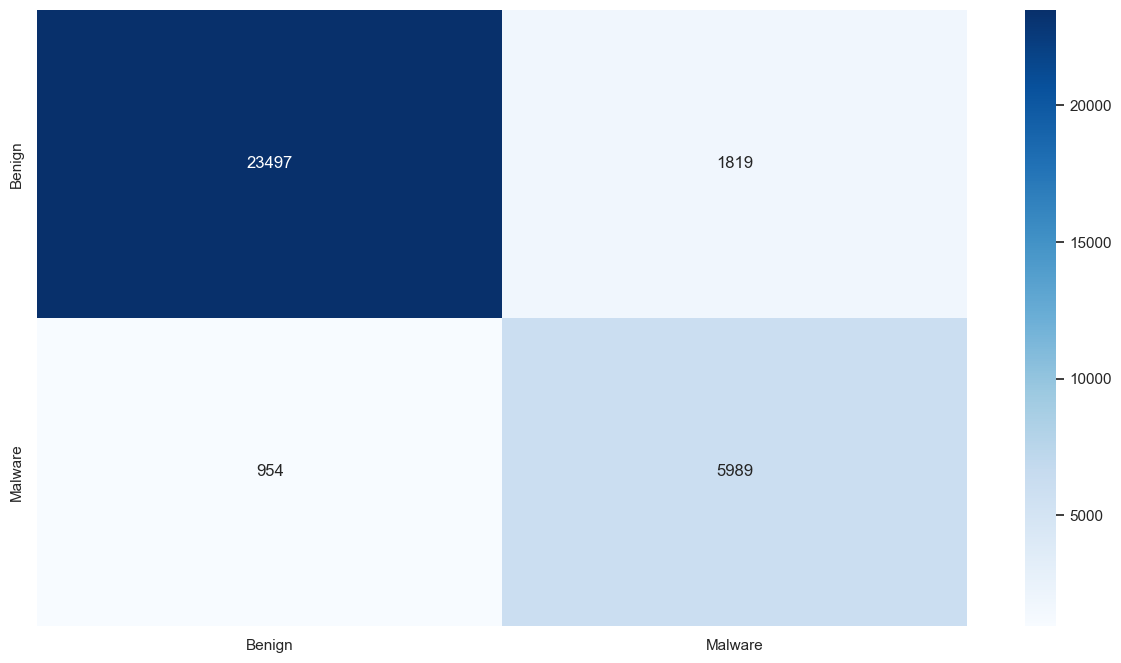

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier

# We choose our model of choice and set it's hyper parameters you can change anything
dtc = DecisionTreeClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = {"random_state": [None,10,20,30,40,50,100,200,300],
             "splitter":["best", "random"],
             "max_depth":[1,2,3,4,5,6,7,8,9,10]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
dtc = GridSearchCV(dtc, parameters)
# Train Model
dtc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
dtc = dtc.best_estimator_
ResultPrintout(dtc)

### Model 3- GradientBoostingClassifier()

[('Benign', 118115), ('Malware', 32393)]
              precision    recall  f1-score   support

      Benign    0.96704   0.97697   0.97198     25316
     Malware    0.91276   0.87858   0.89535      6943

    accuracy                        0.95580     32259
   macro avg    0.93990   0.92778   0.93366     32259
weighted avg    0.95536   0.95580   0.95549     32259



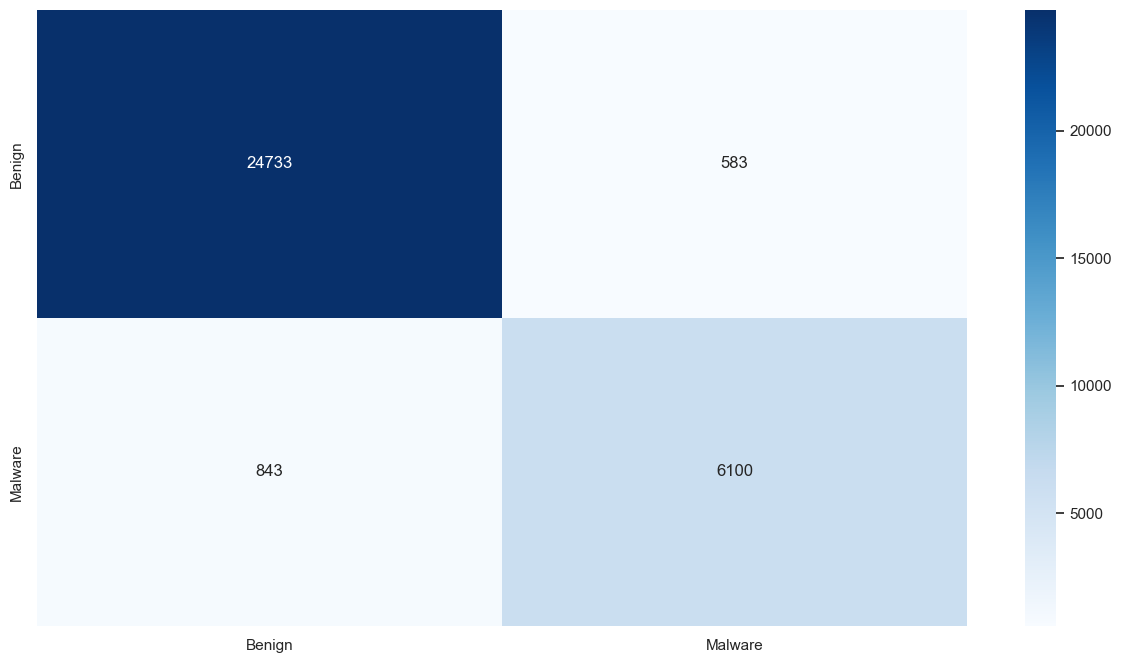

In [14]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
gbc = GradientBoostingClassifier()

parameters = {"n_estimators": [50,100,200,300,350,400]}

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
gbc = GridSearchCV(gbc, parameters)
# Train Model
gbc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
gbc = gbc.best_estimator_
ResultPrintout(gbc)


### Model 4- AdaBoostClassifier()

[('Benign', 118115), ('Malware', 32393)]
              precision    recall  f1-score   support

      Benign    0.95042   0.96469   0.95750     25316
     Malware    0.86378   0.81651   0.83948      6943

    accuracy                        0.93279     32259
   macro avg    0.90710   0.89060   0.89849     32259
weighted avg    0.93177   0.93279   0.93210     32259



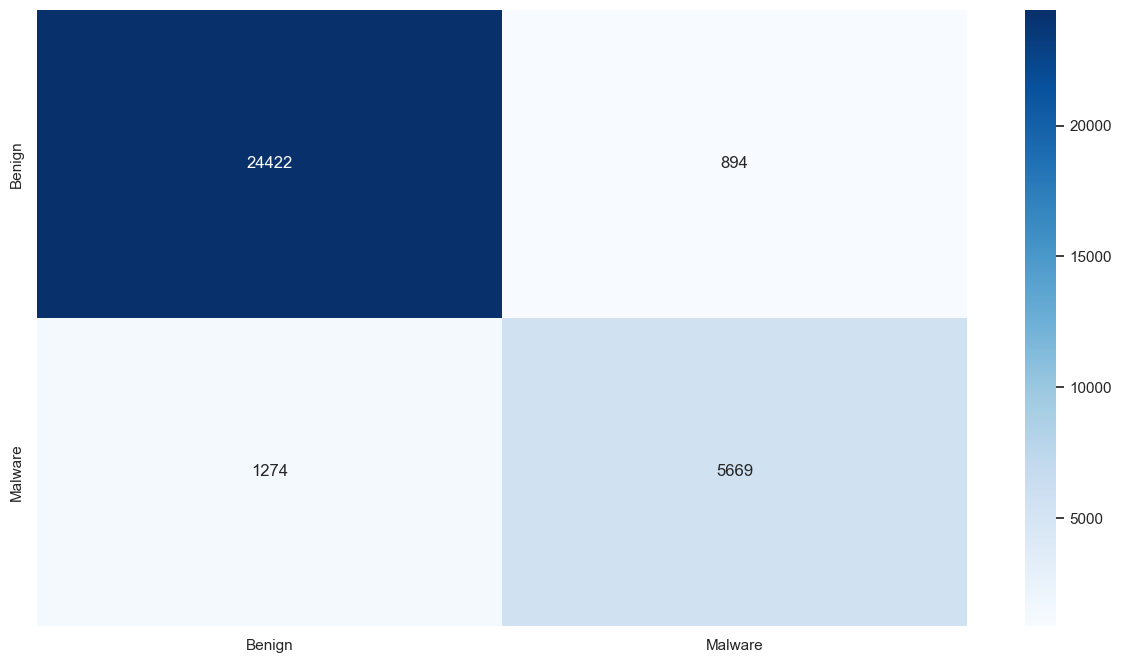

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
from sklearn.ensemble import AdaBoostClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
abc = AdaBoostClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = {"random_state": [None,10,20,30,40,50,100,200,300],
              "n_estimators": [50,100,200,300,400]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
abc = GridSearchCV(abc, parameters)
# Train Model
abc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
abc = abc.best_estimator_
ResultPrintout(abc)

### Model 5- ExtraTreesClassifier() 

[('Benign', 118115), ('Malware', 32393)]
              precision    recall  f1-score   support

      Benign    0.96394   0.96512   0.96453     25316
     Malware    0.87225   0.86836   0.87030      6943

    accuracy                        0.94429     32259
   macro avg    0.91810   0.91674   0.91741     32259
weighted avg    0.94421   0.94429   0.94425     32259



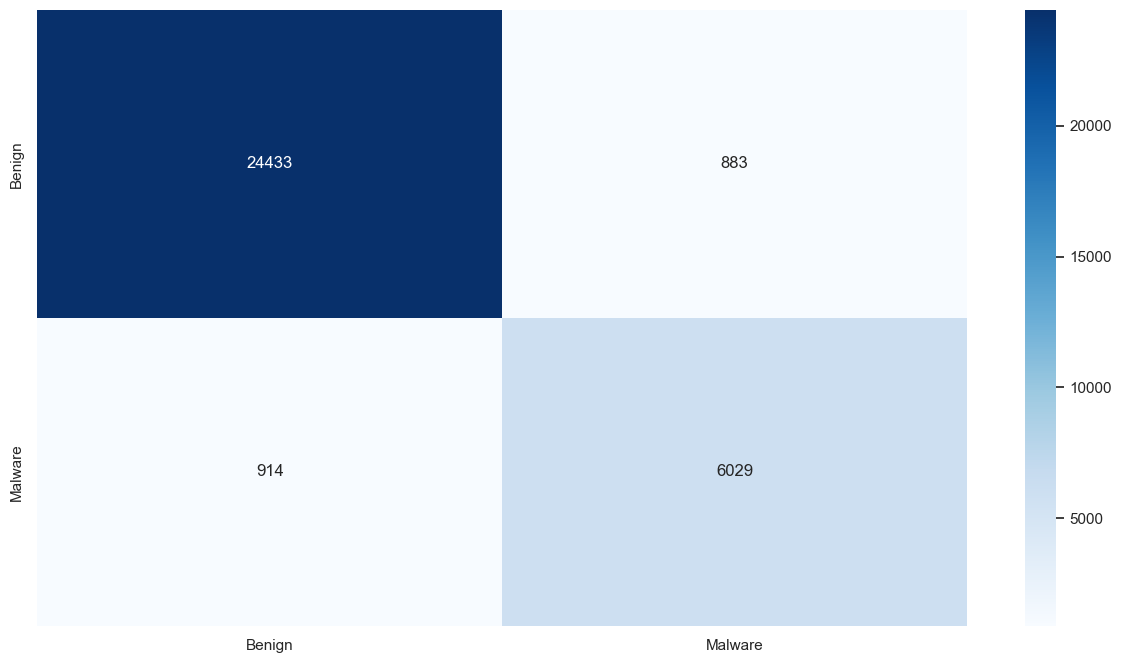

In [16]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
from sklearn.ensemble import ExtraTreesClassifier
#n_estimatorsint, default=100: The number of base estimators in the ensemble.
# We choose our model of choice and set it's hyper parameters you can change anything
etc = ExtraTreesClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = { "n_estimators": [50,100,200,300,400],
              "min_samples_split":[2,3,4]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
etc = GridSearchCV(etc, parameters)
# Train Model
etc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
etc = etc.best_estimator_
ResultPrintout(etc)

### Model 6- HistGradientBoostingClassifier() 

[('Benign', 118115), ('Malware', 32393)]
              precision    recall  f1-score   support

      Benign    0.96600   0.97863   0.97227     25316
     Malware    0.91818   0.87441   0.89576      6943

    accuracy                        0.95620     32259
   macro avg    0.94209   0.92652   0.93402     32259
weighted avg    0.95571   0.95620   0.95581     32259



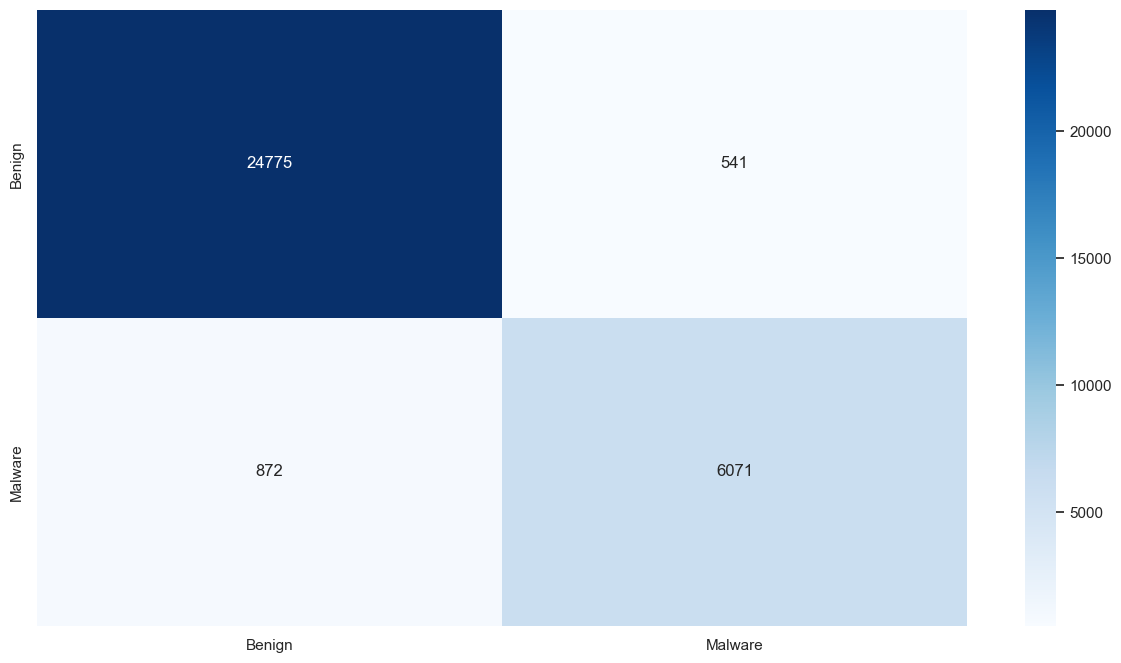

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import HistGradientBoostingClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
hgbc = HistGradientBoostingClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = {"min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
              "max_iter":[20,50,100,200]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
hgbc = GridSearchCV(hgbc, parameters)
# Train Model
hgbc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
hgbc = hgbc.best_estimator_
ResultPrintout(hgbc)

# Choosing the best model

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score
best=0
m=None
models={clf,dtc,gbc,abc,etc,hgbc}
for i in models:
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = i.predict(X_test)
    true_labels = y_test
    if accuracy_score(true_labels, predictions)*100 > best:
        best=accuracy_score(true_labels, predictions)*100
        m=i
print(best)
print(m)
    

95.61982702501628
HistGradientBoostingClassifier(min_samples_leaf=8)


# Test

In [19]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
for column in test_df.columns[test_df.isna().any()].tolist():
    #df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = m.predict(X)
print(m)

HistGradientBoostingClassifier(min_samples_leaf=8)


# Save your predictions

In [20]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')